In [5]:
import importlib
import project_utils.deciles as deciles
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from general_utils import utils
from general_utils.OverallDetailComparisonPlot import OverallDetailComparisonPlot
import os
from matplotlib import colors as mcolors
import math
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import general_utils.LDI_VIF as LV
import numpy as np
import project_utils.binary_classification as bc
importlib.reload(bc)


utils.default_plot_format()
utils.pd_display_settings(3)

In [6]:
data_path = r"processed_data\raw_metrics\processed_10min_Nabian.pkl"
#data_path = r"processed_data\raw_metrics\comorbidities.pkl"

In [7]:
pickled = pd.read_pickle(data_path)
data = pickled["data"]
indicator_columns = pickled["indicator_columns"]
time_metrics = pickled["time_metrics"]
frequency_metrics = pickled["frequency_metrics"]
non_linear_metrics = pickled["non_linear_metrics"]
data.tail()


,t_start,t_end,SDRR,RMSSD,pNN50 (%),Mean HR (bpm),ULF Power,ULF Peak Frequency,ULF Peak Power,VLF Power,...,UCr (g),UACR (mg÷g),Complications,Nephropathy,Retinopathy and cataract,DPN,Heart Disease,atherosclerosis or stenosis,Carotid Plaque,Condition
3250,22212,22812,30.89,24.63,3.13,79.80,2.35e-08,0,1.61e-05,4.24e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
3251,21611,22211,40.47,34.10,13.03,77.50,1.07e-08,0,9.96e-06,2.39e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
3252,21010,21610,38.71,41.98,27.34,75.71,1.28e-09,0.00167,1.49e-06,3.11e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
3253,34218,34818,88.51,31.71,12.61,79.37,1.33e-08,0.00167,1.59e-05,3.19e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
3254,76304,76903,173.75,220.18,22.22,74.74,3.17e-09,0.00167,3.57e-06,1.2e-06,...,10.23,0.43,1,0,0,True,0,0,1,DPN


In [8]:
median_melted = deciles.produce_median_melt(data, indicator_columns)
median_pivot = median_melted.pivot(index=["id", "DPN"], columns="metric", values="value").reset_index()
print(median_pivot.columns)

metrics = ['HF Power', 'SDRR', 'SD2', 'Mean HR (bpm)', 'LF Power', 'DFA α2', 'S',
       'RMSSD', 'SD1']

metrics = time_metrics
#median_melted = median_melted[median_melted["metric"].isin(metrics)]


median_pivot = median_melted.pivot(index=["id", "DPN"], columns="metric", values="value").reset_index()
print(median_pivot.columns)

Index(['id', 'DPN', 'ApEn', 'D2', 'DFA α1', 'DFA α2', 'HF Peak Frequency',
       'HF Power', 'LF Peak Frequency', 'LF Power', 'LF÷HF Ratio',
       'Mean HR (bpm)', 'RMSSD', 'S', 'SD1', 'SD1÷SD2', 'SD2', 'SDRR',
       'SampEn', 'VLF Peak Frequency', 'VLF Power', 'pNN50 (%)'],
      dtype='object', name='metric')
Index(['id', 'DPN', 'ApEn', 'D2', 'DFA α1', 'DFA α2', 'HF Peak Frequency',
       'HF Power', 'LF Peak Frequency', 'LF Power', 'LF÷HF Ratio',
       'Mean HR (bpm)', 'RMSSD', 'S', 'SD1', 'SD1÷SD2', 'SD2', 'SDRR',
       'SampEn', 'VLF Peak Frequency', 'VLF Power', 'pNN50 (%)'],
      dtype='object', name='metric')


# helper functions


In [9]:
def classify_by_feat(data, features):
    print(features)
    log_res, X_scaled, y = bc.logistic_classifier(data, features)
    res = bc.eval_model(log_res, X_scaled, y)

    bc.plot_evaluation_metrics(res, data['DPN'], f"Logistic Regression Evaluation n={len(data)}", (10, 7))
    return res

In [10]:
def plot_vif(data:pd.DataFrame, height=5):
    nan_columns = data[data.isna().any(axis=1)]["feature"].tolist()
    melted_data = data.melt(id_vars=["feature"], value_vars=["Full VIF", "Excluded VIF"], var_name="VIF Type", value_name="VIF Value")
    plt.figure(figsize=(8, height))
   
    sns.barplot(x="VIF Value", y="feature", hue="VIF Type", data=melted_data, dodge=True)
    plt.title(f"VIF for HRV metrics; Excluded variables: {nan_columns}")
    plt.legend()
    plt.xscale('log')
    plt.grid(axis='x', linestyle='-', alpha=0.5)
    plt.grid(axis='x', linestyle='--', which='minor',alpha = 0.5)
    plt.tight_layout()
    plt.show()

# LDA

In [11]:
median = median_melted.pivot(index=["id", "DPN"], columns="metric", values="value").reset_index()

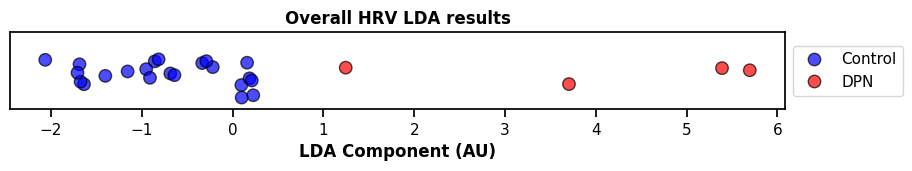

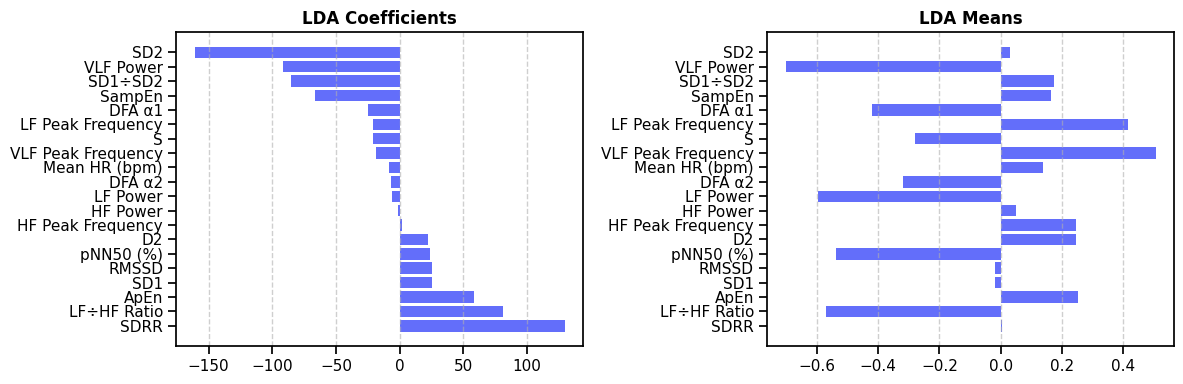

In [12]:
lda_df, lda = LV.perform_lda(median, indicator_columns)
LV.plot_linear_lda(lda_df, "Overall HRV LDA results")
df = LV.show_linear_lda_stats(lda, indicator_columns) 

In [13]:
from IPython.display import display
df_transposed = df.transpose()
df_transposed.columns = df_transposed.loc['Columns']
df_transposed = df_transposed.drop('Columns')
display(df_transposed)


Columns,SDRR,RMSSD,pNN50 (%),Mean HR (bpm),VLF Power,VLF Peak Frequency,LF Power,LF Peak Frequency,HF Power,HF Peak Frequency,LF÷HF Ratio,S,SD1,SD2,SD1÷SD2,ApEn,SampEn,DFA α1,DFA α2,D2
LDA Coef,129.48,25.19,24.01,-8.19,-91.57,-18.46,-5.77,-21.10,-1.18,1.69,81.26,-20.82,25.27,-160.86,-85.57,58.55,-66.36,-24.67,-6.96,22.09
Means,0.00318,-0.0194,-0.54,0.14,-0.70,0.50,-0.60,0.42,0.0501,0.24,-0.57,-0.28,-0.0194,0.0286,0.17,0.25,0.16,-0.42,-0.32,0.25


LDA allows to isolate all of the DPN patients by over-fitting.

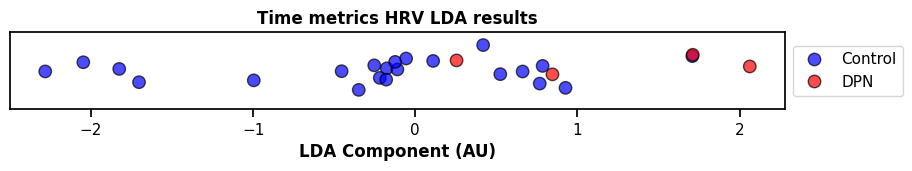

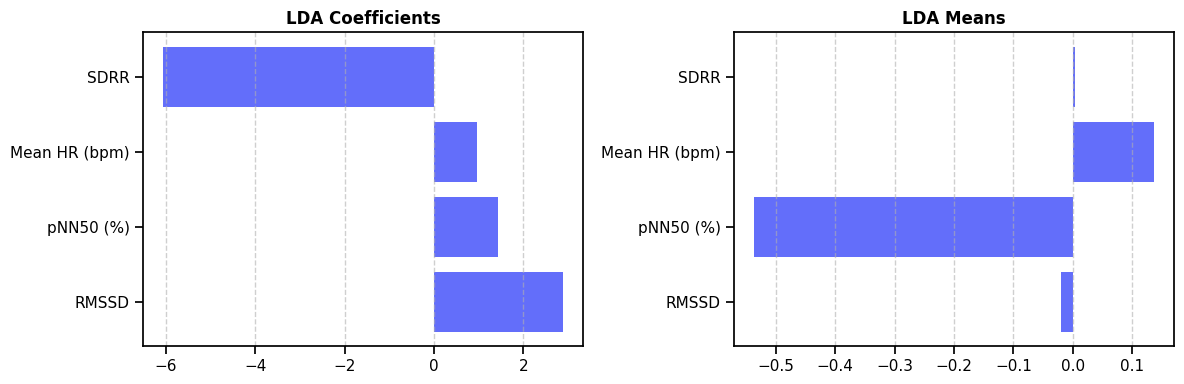

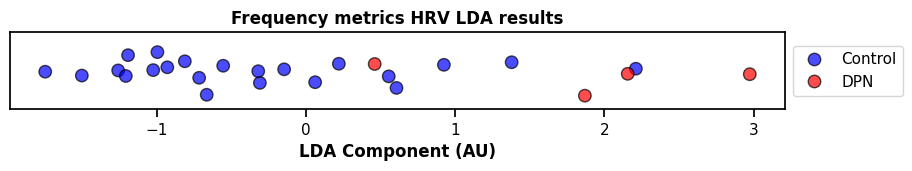

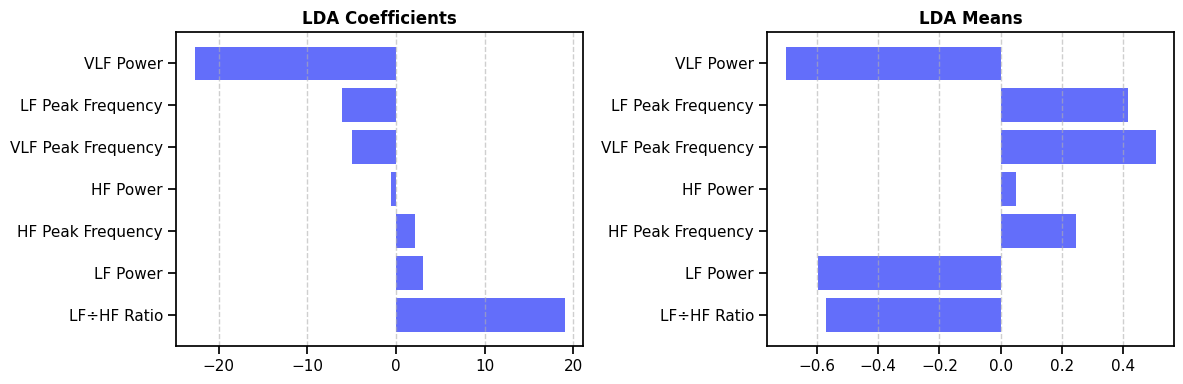

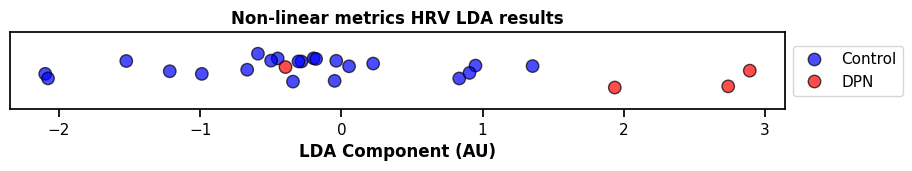

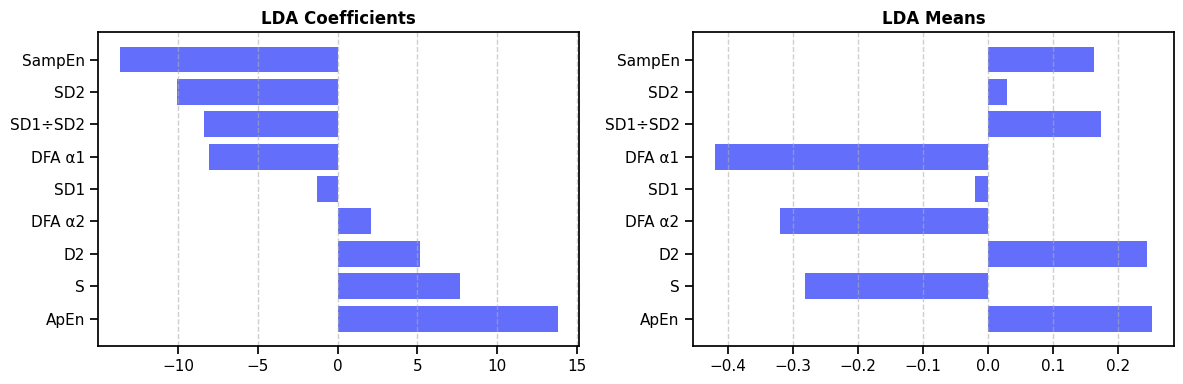

In [14]:
metric_lda = [] 
for col, name in zip([time_metrics, frequency_metrics, non_linear_metrics], ["Time", "Frequency", "Non-linear"]):
    lda_df, lda = LV.perform_lda(median_pivot, col)
    LV.plot_linear_lda(lda_df,  f"{name} metrics HRV LDA results")
    LV.show_linear_lda_stats(lda, col)
    metric_lda.append([lda, lda_df, name])


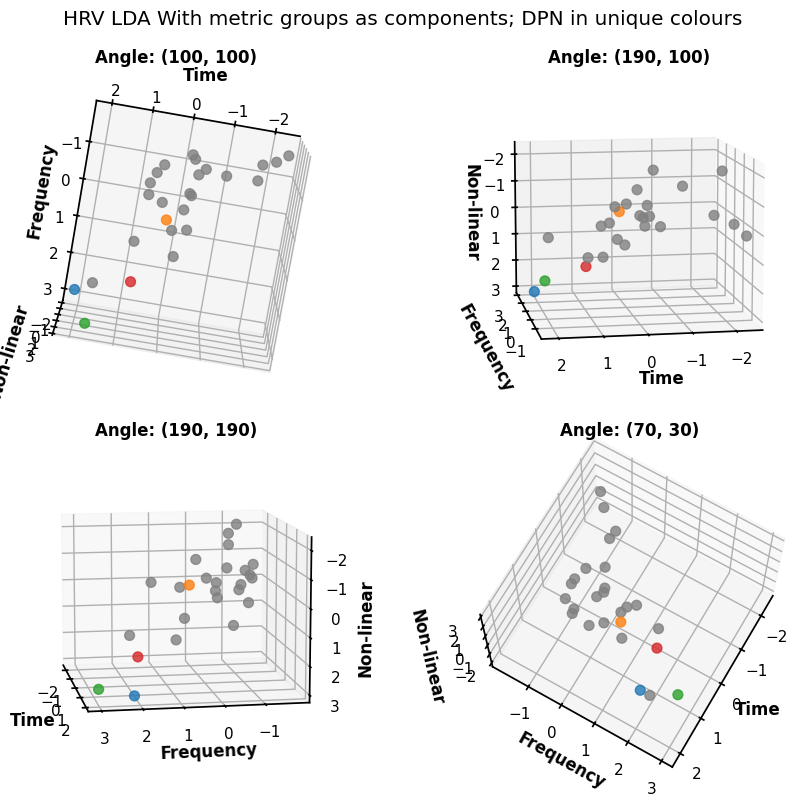

In [15]:
full_df = pd.DataFrame()
for lda, lda_df, name in metric_lda:
    full_df[name] = lda_df[0]
    
full_df["cluster"] = metric_lda[0][1]["Cluster"]


unique_dpn = full_df[full_df['cluster']].index
dpn_colors = {idx: color for idx, color in zip(unique_dpn, mcolors.TABLEAU_COLORS)}

fig = plt.figure(figsize=(10, 8))

# Define the angles for the subplots
angles = [(100, 100), (190, 100), (190, 190), (70, 30)]

fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, angle in enumerate(angles):
    ax = fig.add_subplot(2, 2, i + 1, projection='3d')
    ax.scatter(full_df['Time'], full_df['Frequency'], full_df['Non-linear'], 
               c=[dpn_colors[idx] if idx in dpn_colors else 'gray' for idx in full_df.index], 
               s=50, alpha=0.8)
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('Non-linear')
    ax.view_init(elev=angle[0], azim=angle[1])
    ax.set_title(f'Angle: {angle}')

plt.suptitle('HRV LDA With metric groups as components; DPN in unique colours')
plt.tight_layout()
plt.show()

### LDA Man whitney >0.10

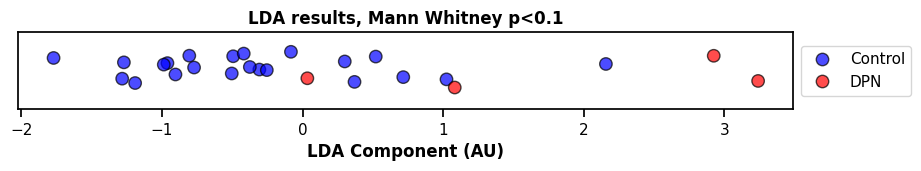

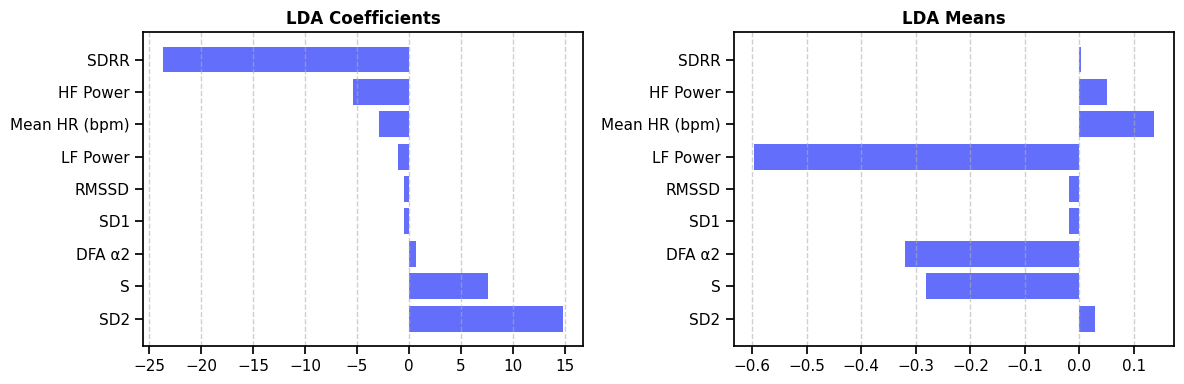

In [16]:
col = ['HF Power', 'SD2', 'SDRR', 'Mean HR (bpm)', 'LF Power', 'DFA α2', 'S',
       'RMSSD', 'SD1']

lda_df, lda = LV.perform_lda(median_pivot, col)
LV.plot_linear_lda(lda_df,  "LDA results, Mann Whitney p<0.1")
df = LV.show_linear_lda_stats(lda, col)

# LDA permutations <0.1

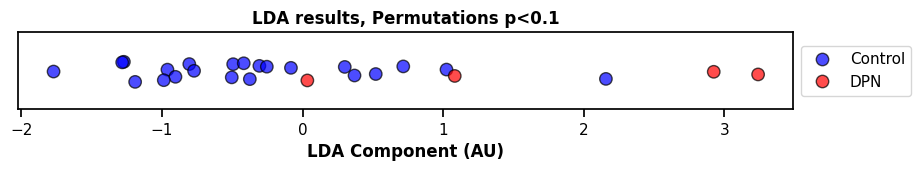

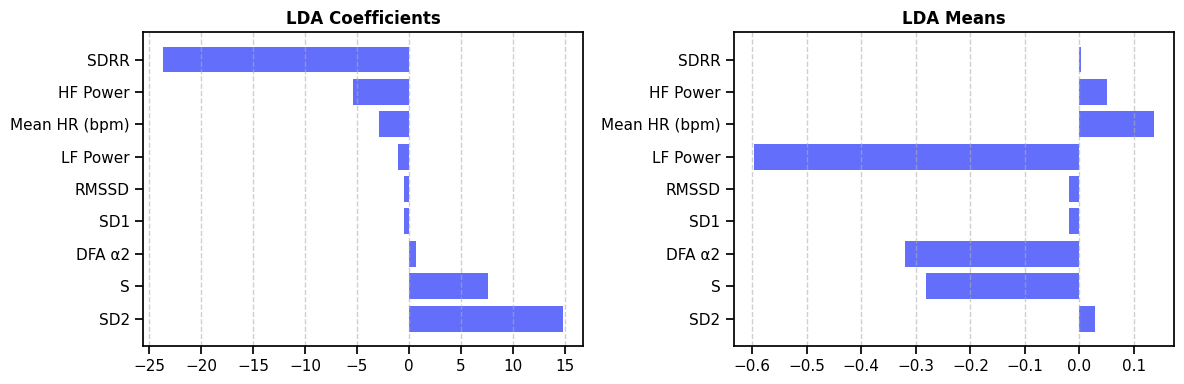

In [17]:
col = ['HF Power', 'SD2', 'SDRR', 'Mean HR (bpm)', 'LF Power', 'DFA α2', 'S',
       'RMSSD', 'SD1']

lda_df, lda = LV.perform_lda(median_pivot, col)
LV.plot_linear_lda(lda_df,  "LDA results, Permutations p<0.1")
df = LV.show_linear_lda_stats(lda, col)

In [18]:
df_transposed = df.transpose()
df_transposed.columns = df_transposed.loc['Columns']
df_transposed = df_transposed.drop('Columns')
display(df_transposed)

Columns,HF Power,SD2,SDRR,Mean HR (bpm),LF Power,DFA α2,S,RMSSD,SD1
LDA Coef,-5.40,14.80,-23.68,-2.91,-1.06,0.62,7.57,-0.45,-0.45
Means,0.0501,0.0286,0.00318,0.14,-0.60,-0.32,-0.28,-0.0194,-0.0194


# Classifier and LDA

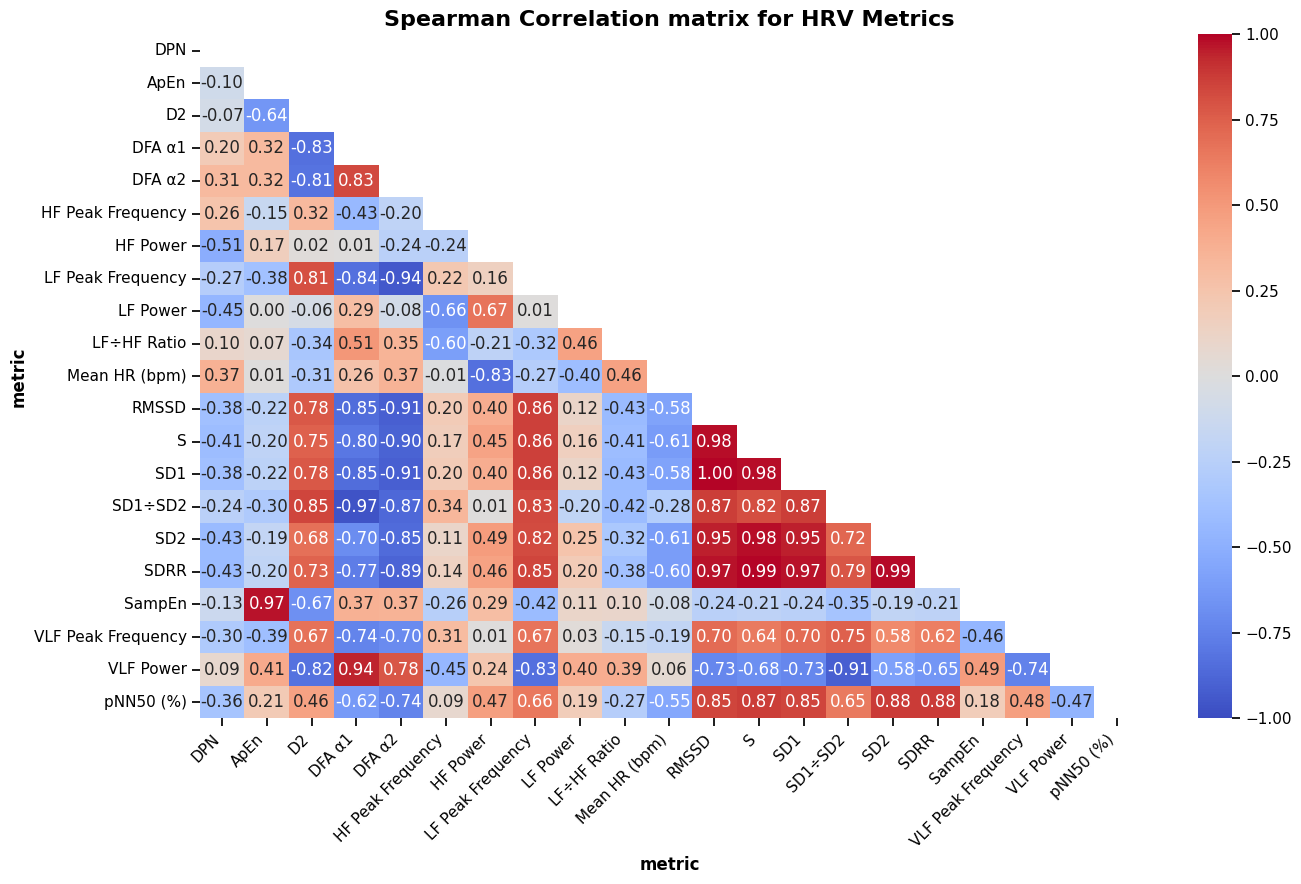

In [19]:
LV.show_correlation(median_pivot.drop(columns='id'), "Spearman Correlation matrix for HRV Metrics", (14, 9))

In [20]:
import general_utils.LDI_VIF as LV
importlib.reload(LV)

LV.get_vif(median.drop(columns =['id', 'DPN']), ['SDRR', 'VLF Power'])

,feature,Full VIF,Excluded VIF
12,SD1,6923762851,6822932830
10,RMSSD,6923560612,6822746774
0,ApEn,4443,3760
16,SampEn,2924,2445
2,DFA α1,1221,1159
9,Mean HR (bpm),1293,967.65
17,VLF Peak Frequency,1335,517.26
13,SD1÷SD2,623.01,454.14
6,LF Peak Frequency,1176,440.81
3,DFA α2,516.75,435.18


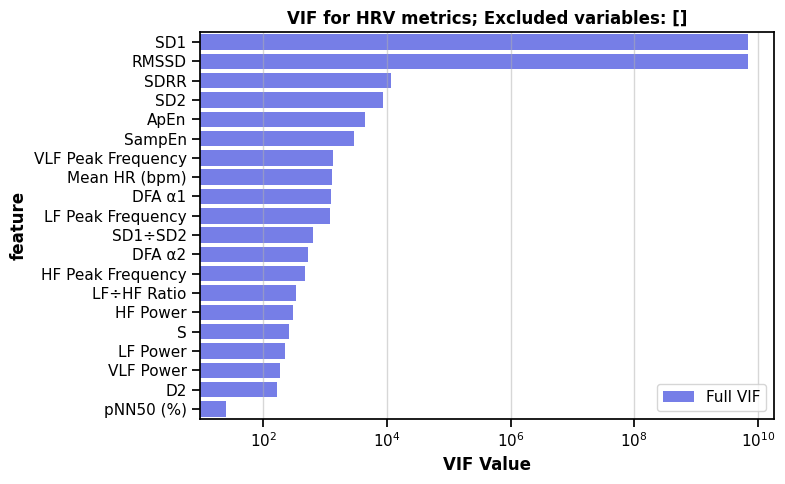

In [21]:


LV.plot_vif(LV.get_vif(median.drop(columns =['id', 'DPN'])))


Log classifier fails to converge, because a separation could not be identified.

## LDA feature isolation

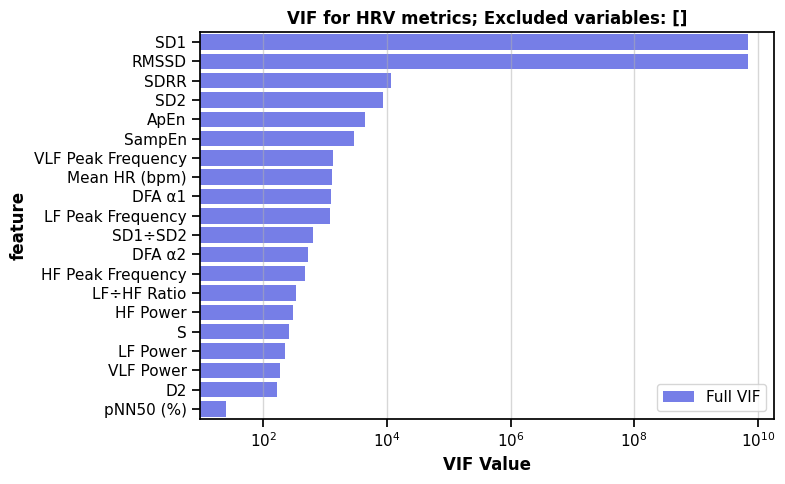

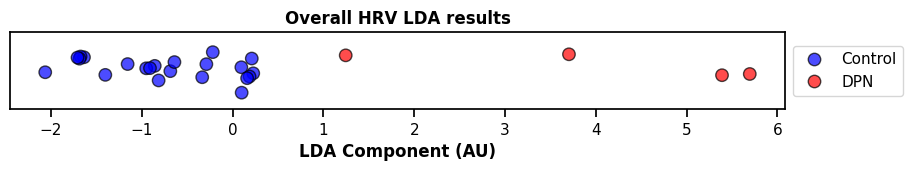

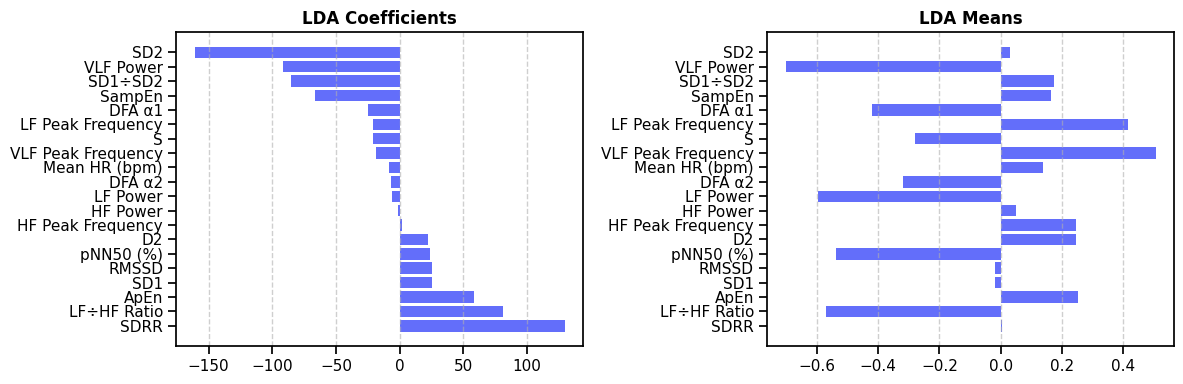

In [22]:
LV.plot_vif(LV.get_vif(median.drop(columns =['id', 'DPN'])))
lda_df, lda = LV.perform_lda(median, indicator_columns)
LV.plot_linear_lda(lda_df, "Overall HRV LDA results")
df = LV.show_linear_lda_stats(lda, indicator_columns)


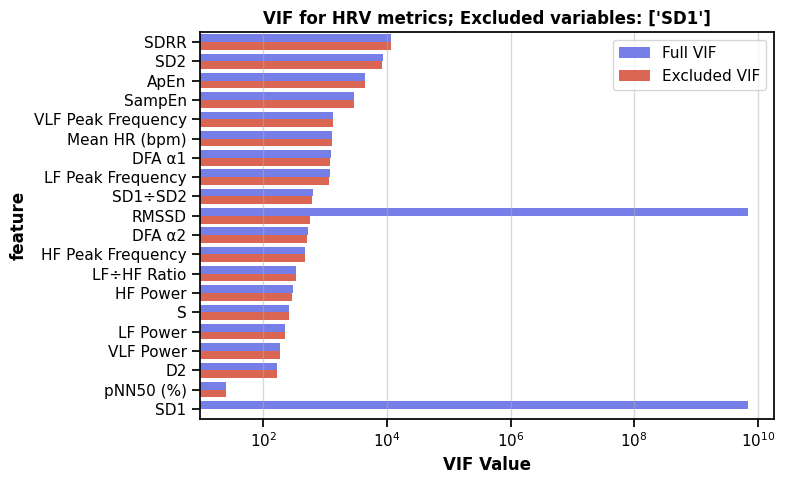

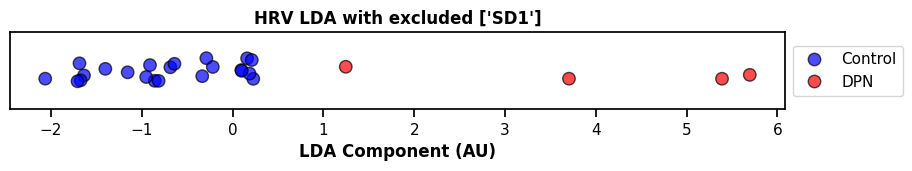

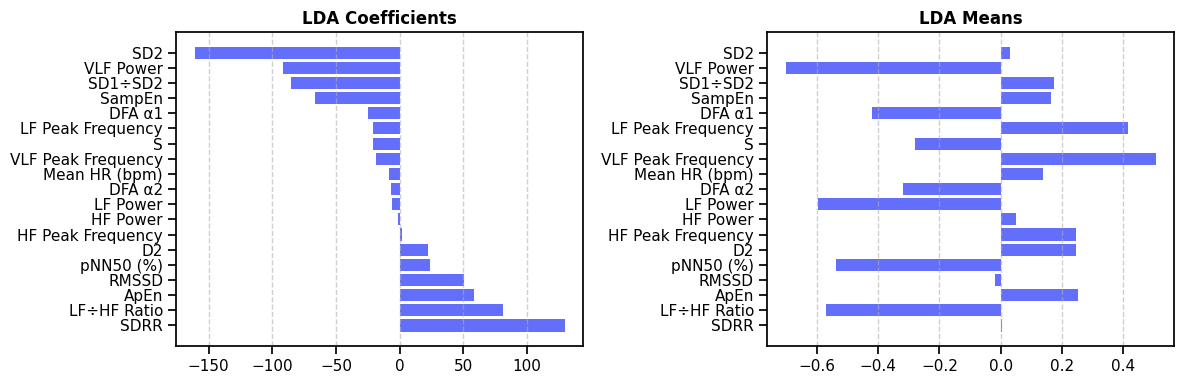

In [23]:
LV.lda_vif_exclude(median, 'SD1')
median = median.drop(columns ='SD1')

SD can be very easily excluded

In [24]:
median.columns

Index(['id', 'DPN', 'ApEn', 'D2', 'DFA α1', 'DFA α2', 'HF Peak Frequency',
       'HF Power', 'LF Peak Frequency', 'LF Power', 'LF÷HF Ratio',
       'Mean HR (bpm)', 'RMSSD', 'S', 'SD1÷SD2', 'SD2', 'SDRR', 'SampEn',
       'VLF Peak Frequency', 'VLF Power', 'pNN50 (%)'],
      dtype='object', name='metric')

index.columns

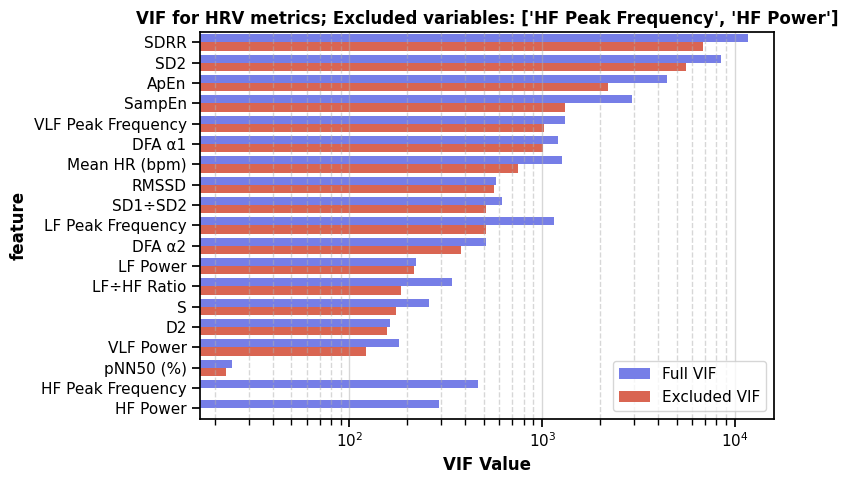

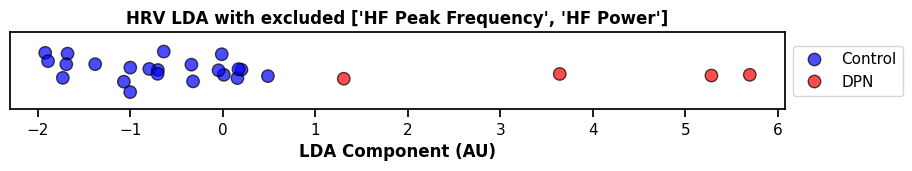

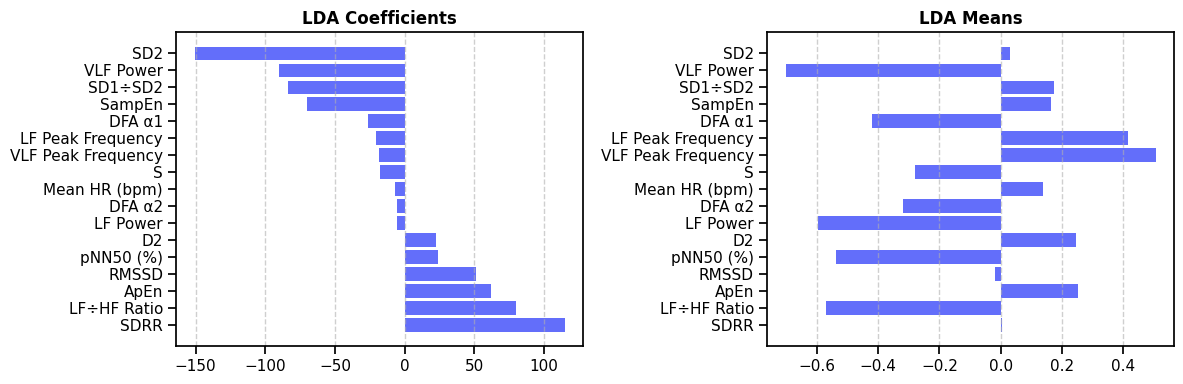

In [25]:
LV.lda_vif_exclude(median, ['HF Peak Frequency', 'HF Power'])
median = median.drop(columns =['HF Peak Frequency', 'HF Power'])


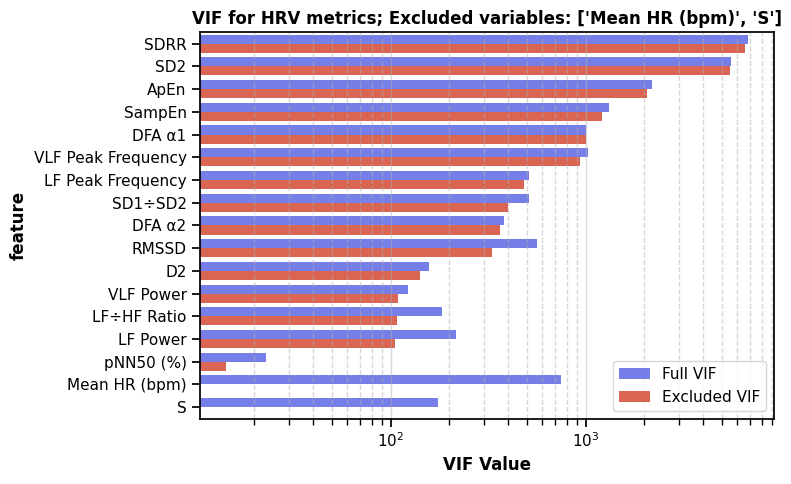

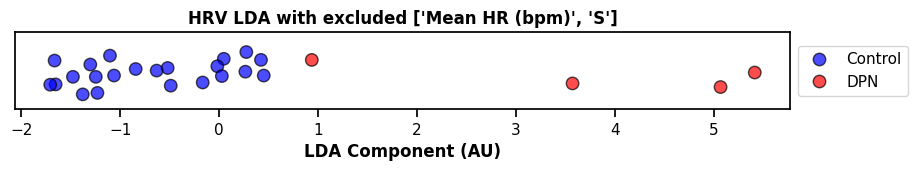

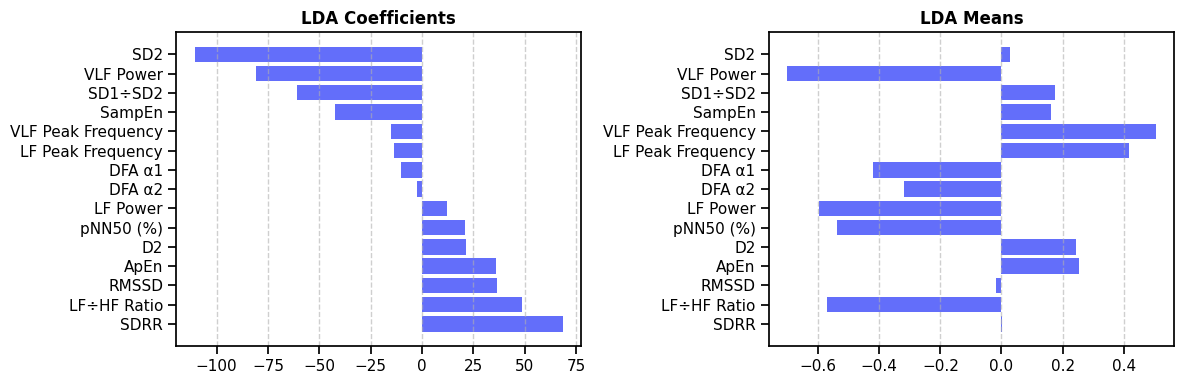

In [26]:
LV.lda_vif_exclude(median, ['Mean HR (bpm)', 'S'])
median = median.drop(columns =['Mean HR (bpm)', 'S'])

In [27]:
median.columns

Index(['id', 'DPN', 'ApEn', 'D2', 'DFA α1', 'DFA α2', 'LF Peak Frequency',
       'LF Power', 'LF÷HF Ratio', 'RMSSD', 'SD1÷SD2', 'SD2', 'SDRR', 'SampEn',
       'VLF Peak Frequency', 'VLF Power', 'pNN50 (%)'],
      dtype='object', name='metric')

SD2 is too important for separation to drop

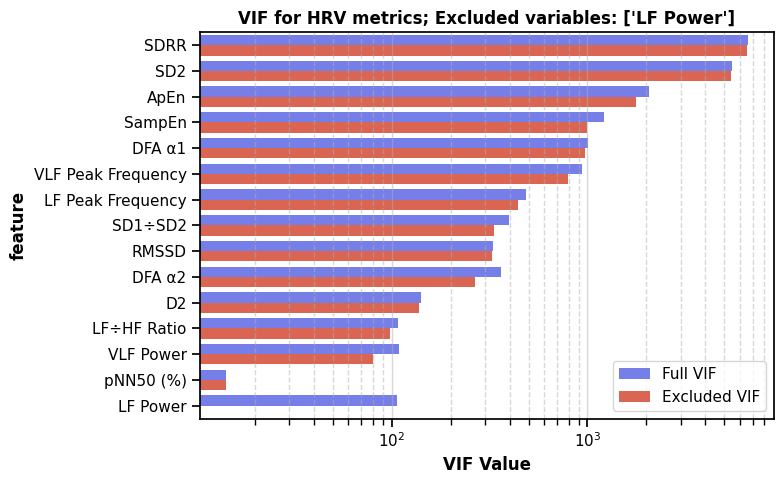

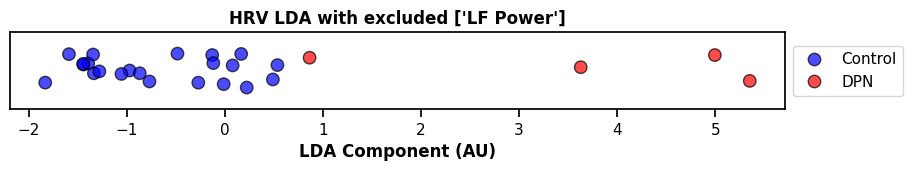

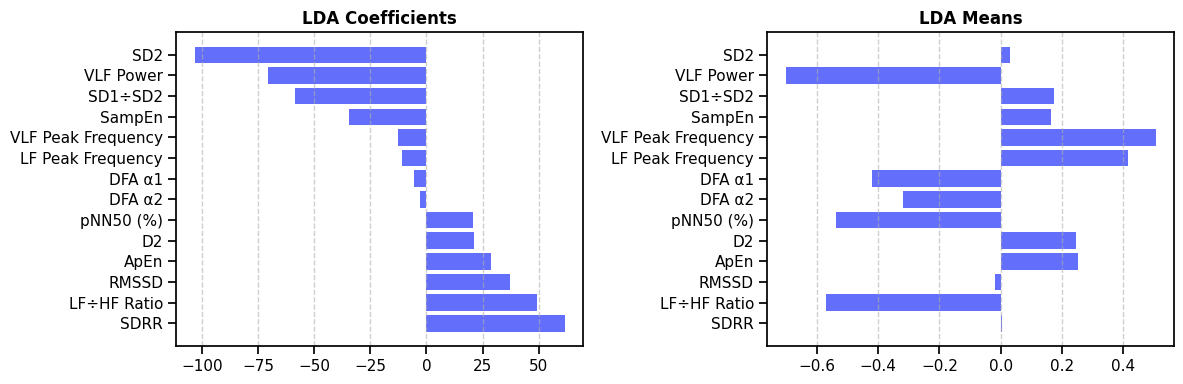

In [28]:
LV.lda_vif_exclude(median, ['LF Power', ])
median = median.drop(columns =['LF Power'])


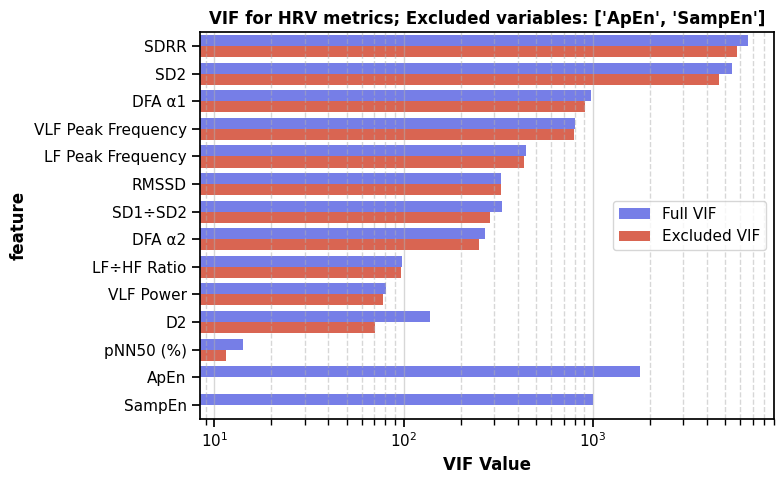

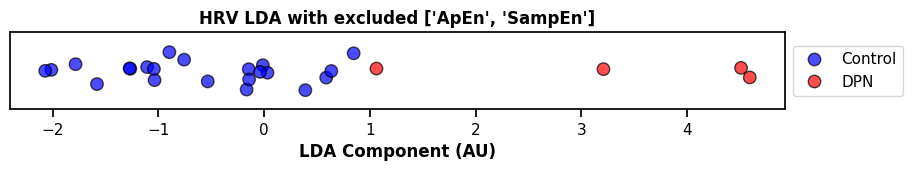

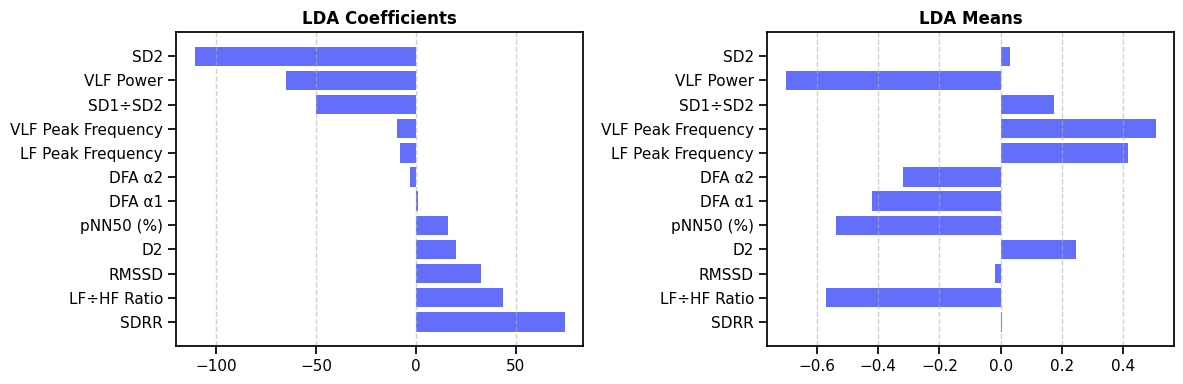

In [29]:
LV.lda_vif_exclude(median, ['ApEn', 'SampEn'])
median = median.drop(columns =['ApEn', 'SampEn'])

In [30]:
median.columns

Index(['id', 'DPN', 'D2', 'DFA α1', 'DFA α2', 'LF Peak Frequency',
       'LF÷HF Ratio', 'RMSSD', 'SD1÷SD2', 'SD2', 'SDRR', 'VLF Peak Frequency',
       'VLF Power', 'pNN50 (%)'],
      dtype='object', name='metric')

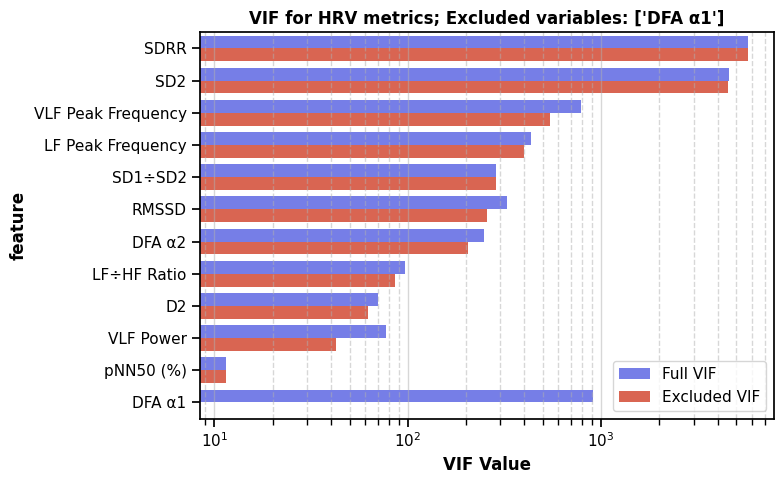

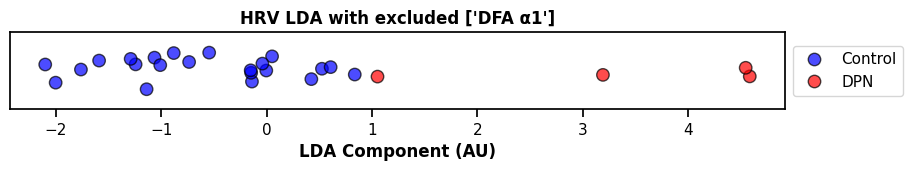

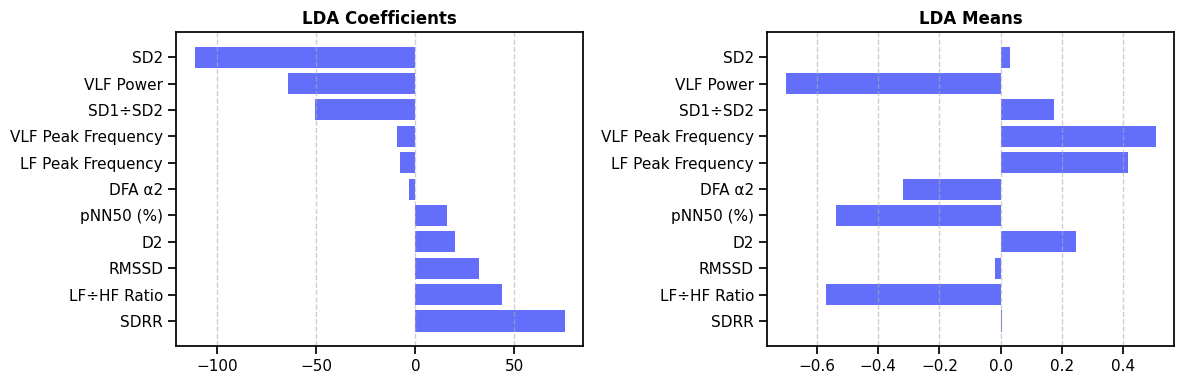

In [31]:
LV.lda_vif_exclude(median, ['DFA α1'])
data.drop(columns =['DFA α1']);


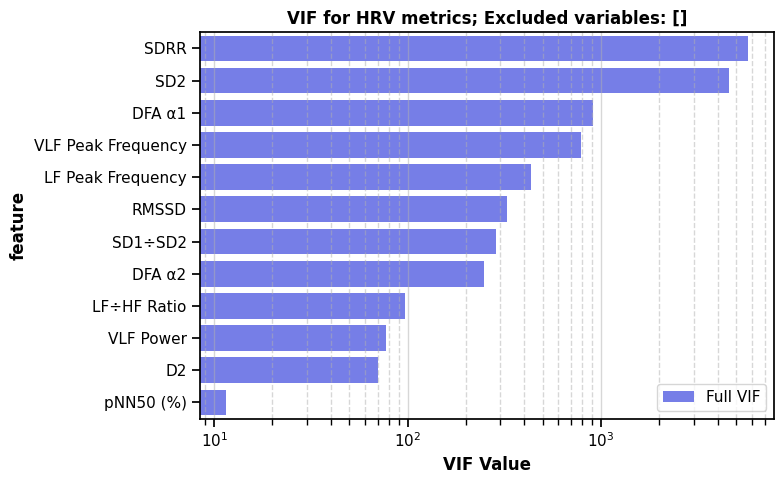

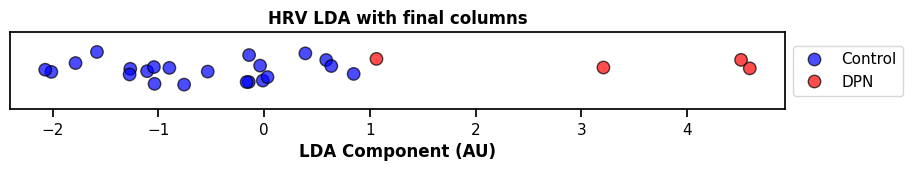

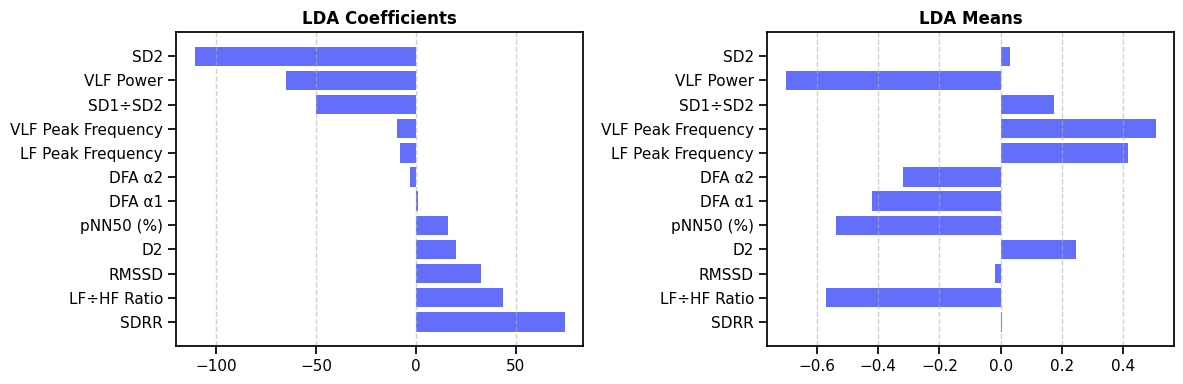

In [32]:
def show_current_lda(median, title = "HRV LDA with final columns"):
    columns = [columns for columns in median.columns if columns not in ['id', 'DPN']]

    LV.plot_vif(LV.get_vif(median.drop(columns =['id', 'DPN'])))
    lda_df, lda = LV.perform_lda(median, columns)
    LV.plot_linear_lda(lda_df, title)
    LV.show_linear_lda_stats(lda, columns)

show_current_lda(median)

### Result interpretation

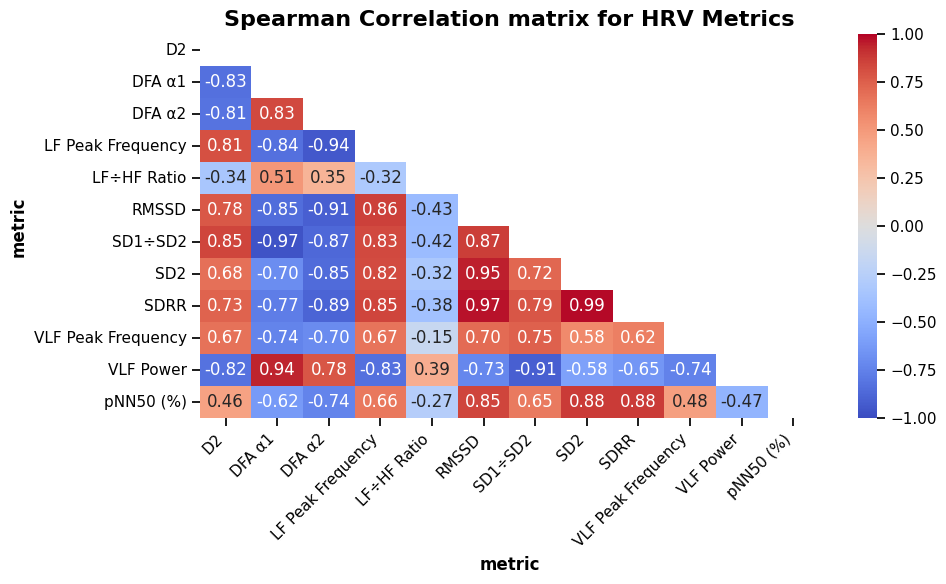

In [33]:
LV.show_correlation(median.drop(columns=['id', 'DPN']), "Spearman Correlation matrix for HRV Metrics", (10,6))

In [34]:
try:
    features = [columns for columns in median.columns if columns not in ['id', 'DPN']]
    classify_by_feat(median, features)
except:
    print("Error in classification")

['D2', 'DFA α1', 'DFA α2', 'LF Peak Frequency', 'LF÷HF Ratio', 'RMSSD', 'SD1÷SD2', 'SD2', 'SDRR', 'VLF Peak Frequency', 'VLF Power', 'pNN50 (%)']
         Current function value: inf
         Iterations: 1000
Error in classification


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


## Sacrifice of predictive power for separation

In [35]:
median.columns

Index(['id', 'DPN', 'D2', 'DFA α1', 'DFA α2', 'LF Peak Frequency',
       'LF÷HF Ratio', 'RMSSD', 'SD1÷SD2', 'SD2', 'SDRR', 'VLF Peak Frequency',
       'VLF Power', 'pNN50 (%)'],
      dtype='object', name='metric')

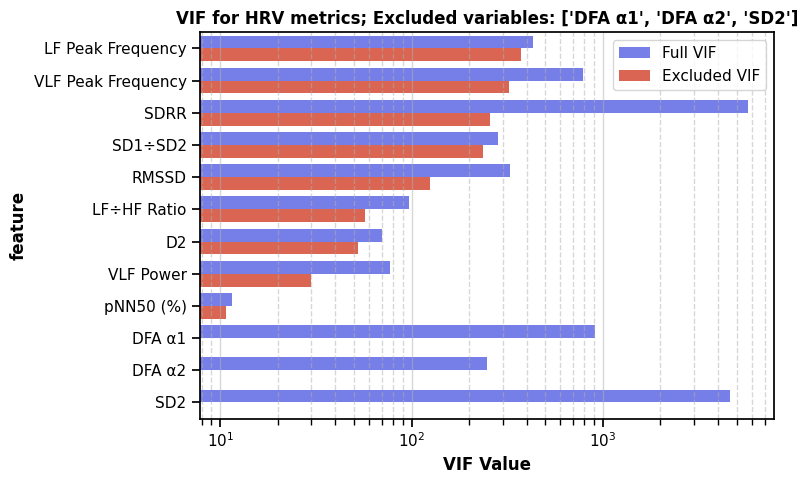

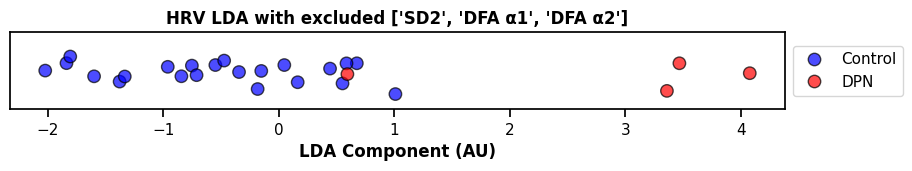

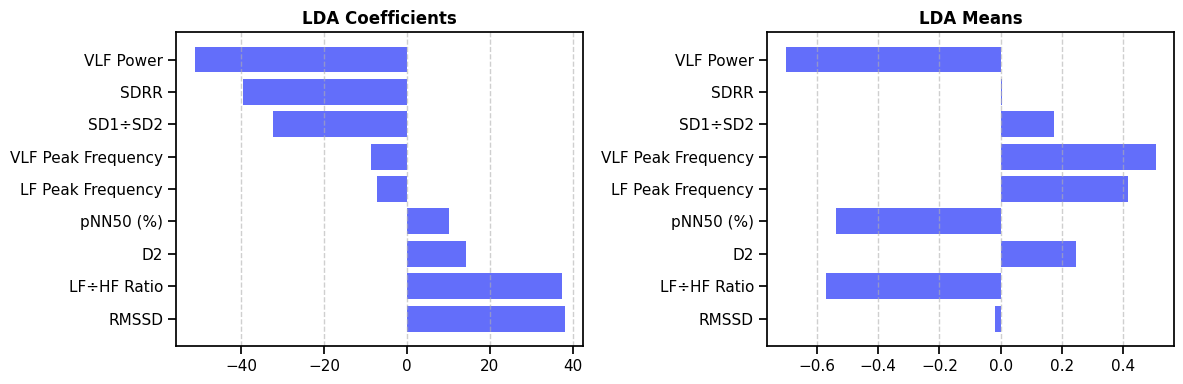

In [36]:
LV.lda_vif_exclude(median, ['SD2','DFA α1', 'DFA α2'])
less_sep = median.copy().drop(columns = ['SD2','DFA α1', 'DFA α2'])


In [37]:
try:
    features = [columns for columns in less_sep.columns if columns not in ['id', 'DPN']]
    classify_by_feat(less_sep, features)
except:
    print("Error in classification")

['D2', 'LF Peak Frequency', 'LF÷HF Ratio', 'RMSSD', 'SD1÷SD2', 'SDRR', 'VLF Peak Frequency', 'VLF Power', 'pNN50 (%)']
         Current function value: inf
         Iterations: 1000
Error in classification


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Removal of SD2 produces very tight distribution for all but one component.

              precision    recall  f1-score   support

       False       1.00      1.00      1.00        22
        True       1.00      1.00      1.00         4

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26

Number of nodes in the decision tree: 9


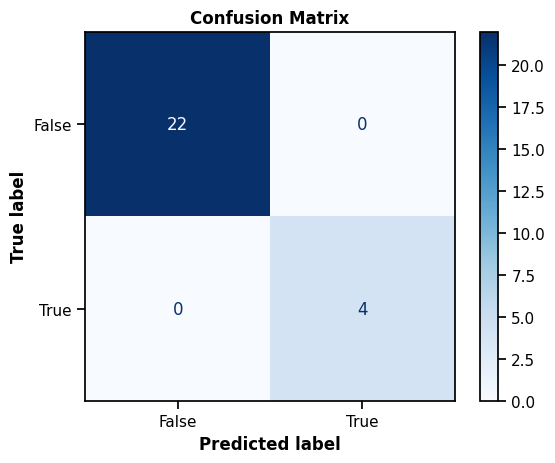

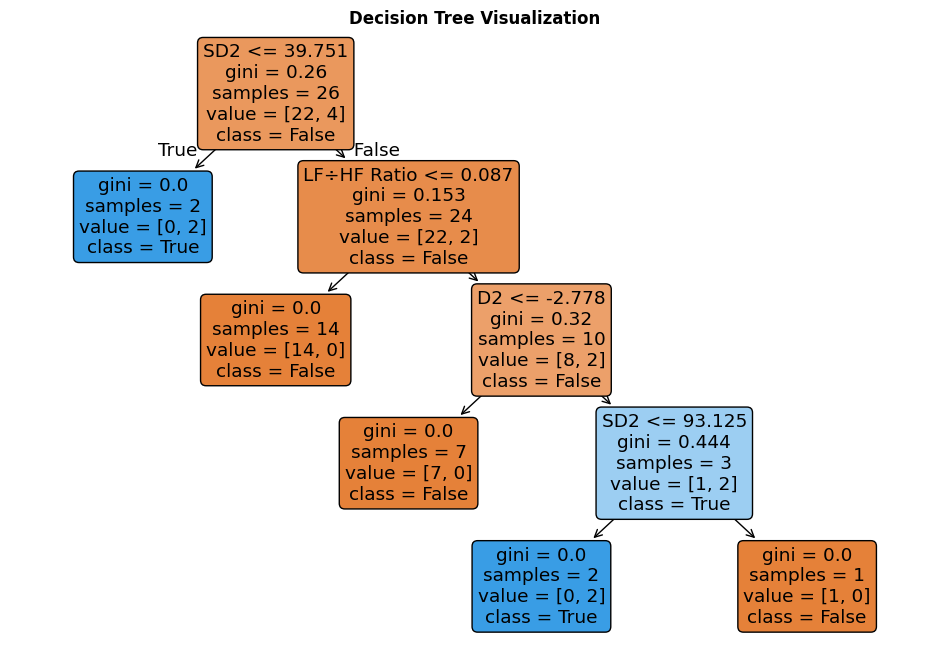

In [38]:
from sklearn.tree import plot_tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Prepare the data
X = median.drop(columns=['id', 'DPN'])
y = median['DPN']

# Fit the decision tree
clf = DecisionTreeClassifier(random_state=42, max_leaf_nodes=5)
clf.fit(X, y)

# Predict and evaluate
y_pred = clf.predict(X)
print(classification_report(y, y_pred))

print(f"Number of nodes in the decision tree: {clf.tree_.node_count}")

# Plot the confusion matrix
ConfusionMatrixDisplay.from_predictions(y, y_pred, display_labels=['False', 'True'], cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=X.columns, class_names=['False', 'True'], filled=True, rounded=True)
plt.title("Decision Tree Visualization")
plt.show()

# Automatic VIF LDA

Removed: SD1
Removed: SDRR
Removed: ApEn
Removed: Mean HR (bpm)
Removed: VLF Peak Frequency
Removed: DFA α1
Removed: LF Peak Frequency
Removed: RMSSD
Removed: HF Peak Frequency
Removed: DFA α2
Removed: SD2
Removed: LF÷HF Ratio
Removed: SampEn
Removed: LF Power
Removed: HF Power
Remaining features: ['D2', 'S', 'SD1÷SD2', 'VLF Power', 'pNN50 (%)']


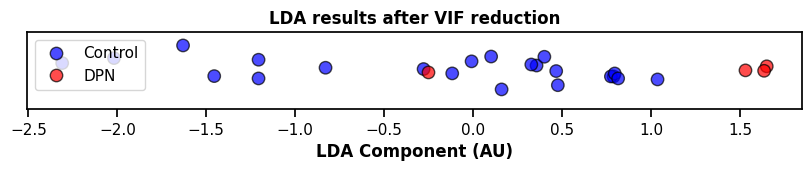

In [39]:
import importlib
import general_utils.LDI_VIF as LV
importlib.reload(LV)

vif_median = median_pivot.copy()
removed_features = []
n = 5

for _ in range(20-n):
    vif_data = LV.get_vif(vif_median.drop(columns=['id', 'DPN']))
    max_vif_value = vif_data["Full VIF"].max()
    if max_vif_value < 5:
        break
    max_vif_col = vif_data.loc[vif_data["Full VIF"] == max_vif_value, "feature"].iloc[0]
    vif_median = vif_median.drop(columns=[max_vif_col])
    removed_features.append(max_vif_col)
    print(f"Removed: {max_vif_col}")

remaining_features = [col for col in vif_median.columns if col not in removed_features + ['id', 'DPN']]
print(f"Remaining features: {remaining_features}")
lda_df, lda = LV.perform_lda(vif_median, remaining_features)
LV.plot_linear_lda(lda_df, "LDA results after VIF reduction")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, ['Control', 'DPN'])
#LV.show_linear_lda_stats(lda, remaining_features)
#LV.plot_vif(LV.get_vif(vif_median.drop(columns=['id', 'DPN'])))

#print(lda_df)


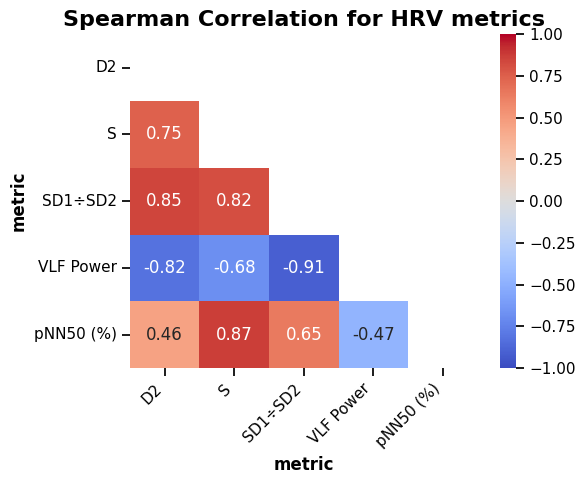

In [40]:
LV.show_correlation(vif_median.drop(columns=['id', 'DPN']), "Spearman Correlation for HRV metrics", (6,5))


# Old features

['D2', 'S', 'SD1÷SD2', 'VLF Power', 'pNN50 (%)']
Optimization terminated successfully.
         Current function value: 0.215586
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                    DPN   No. Observations:                   26
Model:                          Logit   Df Residuals:                       20
Method:                           MLE   Df Model:                            5
Date:                Mon, 14 Apr 2025   Pseudo R-squ.:                  0.4978
Time:                        10:57:37   Log-Likelihood:                -5.6052
converged:                       True   LL-Null:                       -11.162
Covariance Type:            nonrobust   LLR p-value:                   0.04916
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.6631      4.325     -1.541      0.123    

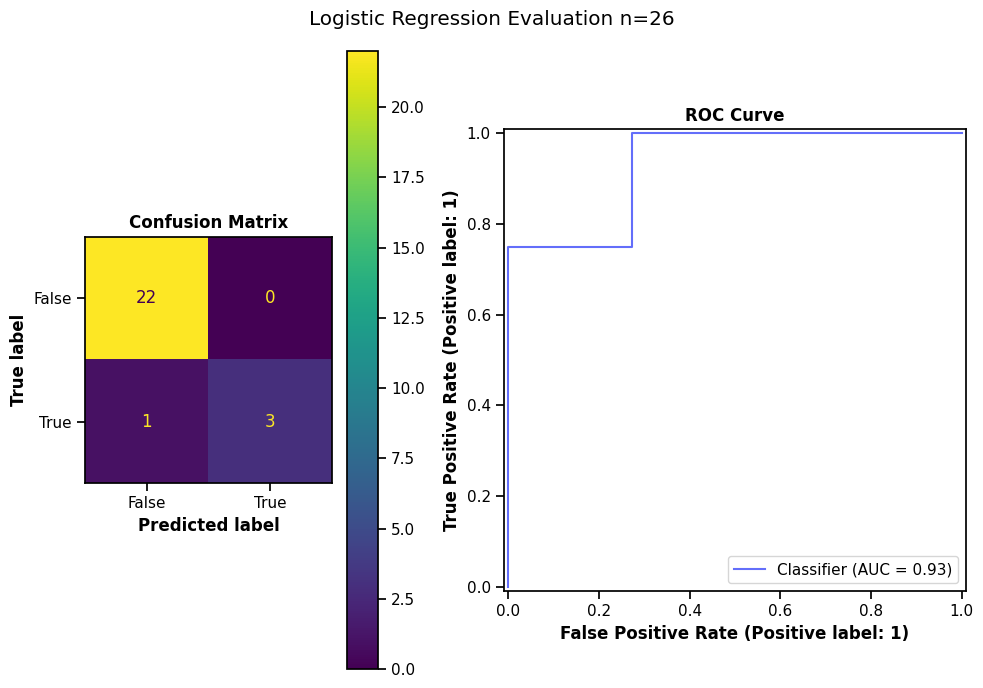

In [41]:
old_features = ['D2', 'SD1÷SD2', 'S', 'VLF Power', 'pNN50 (%)']
# Added with addition of patients data
res = classify_by_feat(median_pivot, remaining_features);

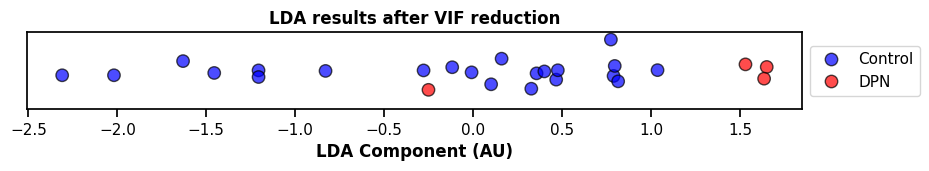

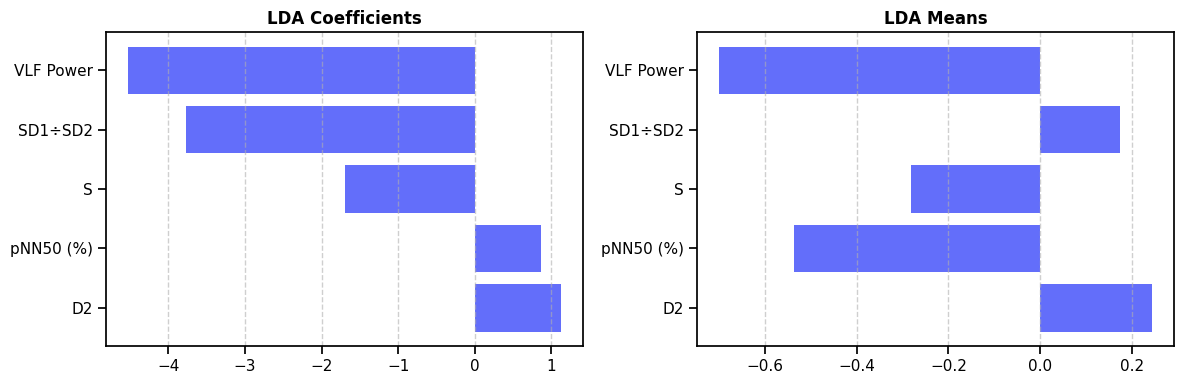

,Columns,LDA Coef,Means
0,D2,1.13,0.25
1,S,-1.69,-0.28
2,SD1÷SD2,-3.77,0.17
3,VLF Power,-4.53,-0.70
4,pNN50 (%),0.87,-0.54


In [42]:
lda_df, lda = LV.perform_lda(median_pivot, remaining_features)
LV.plot_linear_lda(lda_df, "LDA results after VIF reduction")
LV.show_linear_lda_stats(lda, remaining_features)

In [43]:
remaining_features

['D2', 'S', 'SD1÷SD2', 'VLF Power', 'pNN50 (%)']

In [44]:
plots = median_pivot.copy()
exclude = [feature for feature in plots if feature not in (remaining_features + ['id', 'DPN'])]
print(exclude)

['ApEn', 'DFA α1', 'DFA α2', 'HF Peak Frequency', 'HF Power', 'LF Peak Frequency', 'LF Power', 'LF÷HF Ratio', 'Mean HR (bpm)', 'RMSSD', 'SD1', 'SD2', 'SDRR', 'SampEn', 'VLF Peak Frequency']


['ApEn', 'DFA α1', 'DFA α2', 'HF Peak Frequency', 'HF Power', 'LF Peak Frequency', 'LF Power', 'LF÷HF Ratio', 'Mean HR (bpm)', 'RMSSD', 'SD1', 'SD2', 'SDRR', 'SampEn', 'VLF Peak Frequency']


C:\Users\USER\AppData\Local\Temp\ipykernel_23548\2464129880.py:7: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 1e10)


Text(-71.75, 0.5, 'Feature')

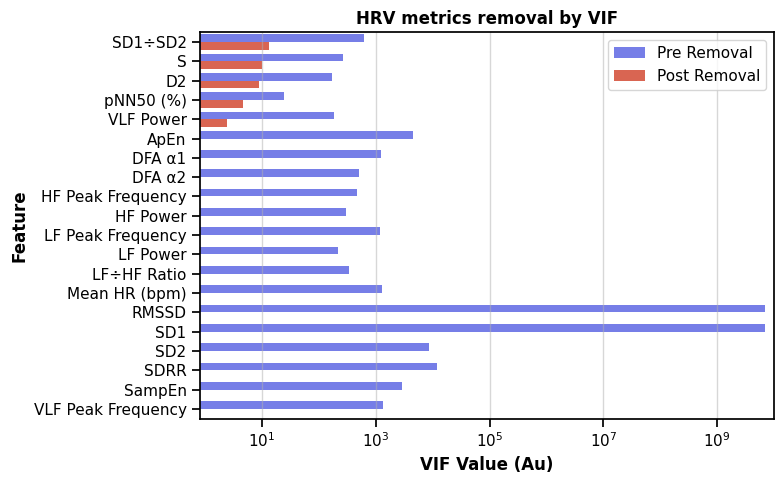

In [45]:
importlib.reload(LV)
plots = median_pivot.copy()
drop = [feature for feature in plots if feature not in (remaining_features + ['id', 'DPN'])]
print(drop)
LV.plot_vif_exclude(plots, drop)
plt.title("HRV metrics removal by VIF")
plt.xlim(0, 1e10)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, ["Pre Removal", "Post Removal"])
plt.xlabel("VIF Value (Au)")
plt.ylabel("Feature") 

['SD1', 'SDRR', 'ApEn', 'Mean HR (bpm)', 'VLF Peak Frequency', 'DFA α1', 'LF Peak Frequency', 'RMSSD', 'HF Peak Frequency', 'DFA α2', 'SD2', 'LF÷HF Ratio', 'SampEn', 'LF Power', 'HF Power', 'SD1÷SD2', 'S', 'D2', 'VLF Power']


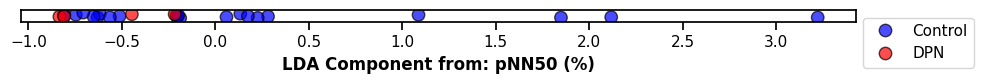

In [46]:
import importlib
import general_utils.LDI_VIF as LV
importlib.reload(LV)



def vif_reduction(data, n=5):
    vif_median = data.copy()
    removed_features = []

    for _ in range(20 - n):
        vif_data = LV.get_vif(vif_median.drop(columns=['id', 'DPN']))
        max_vif_value = vif_data["Full VIF"].max()


        max_vif_col = vif_data.loc[vif_data["Full VIF"] == max_vif_value, "feature"].iloc[0]
        vif_median = vif_median.drop(columns=[max_vif_col])
        removed_features.append(max_vif_col)
        #print(f"Removed: {max_vif_col}")

    remaining_features = [col for col in vif_median.columns if col not in removed_features + ['id', 'DPN']]
    #print(f"Remaining features: {remaining_features}")



    lda_df, lda = LV.perform_lda(vif_median, remaining_features)
    LV.plot_linear_lda(lda_df, "LDA results after VIF reduction")
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, ['Control', 'DPN'], loc='upper left', bbox_to_anchor=(1, 1))
    plt.title(None)

    if len(remaining_features)<6:
        plt.xlabel(f"LDA Component from: {', '.join(remaining_features)}")
    else:
        plt.xlabel(f"LDA Component from {len(remaining_features)} metrics")

    plt.tight_layout()
    plt.savefig(f"images/LDA/VIF_reduction_n{n}.png", dpi=600)

    print(removed_features)
    return remaining_features, lda_df, lda


# Example usage
remaining_features, lda_df, lda = vif_reduction(median_pivot.copy(), n=1)

#print(lda_df)


[]
['SD1', 'SDRR', 'ApEn', 'Mean HR (bpm)', 'VLF Peak Frequency']
['SD1', 'SDRR', 'ApEn', 'Mean HR (bpm)', 'VLF Peak Frequency', 'DFA α1', 'LF Peak Frequency', 'RMSSD', 'HF Peak Frequency', 'DFA α2']
['SD1', 'SDRR', 'ApEn', 'Mean HR (bpm)', 'VLF Peak Frequency', 'DFA α1', 'LF Peak Frequency', 'RMSSD', 'HF Peak Frequency', 'DFA α2', 'SD2', 'LF÷HF Ratio', 'SampEn', 'LF Power', 'HF Power']
['SD1', 'SDRR', 'ApEn', 'Mean HR (bpm)', 'VLF Peak Frequency', 'DFA α1', 'LF Peak Frequency', 'RMSSD', 'HF Peak Frequency', 'DFA α2', 'SD2', 'LF÷HF Ratio', 'SampEn', 'LF Power', 'HF Power', 'SD1÷SD2']


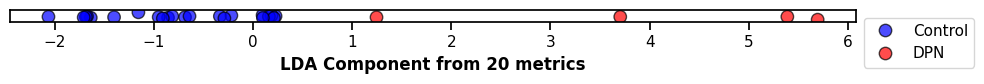

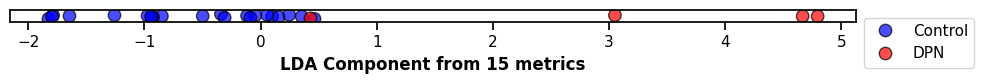

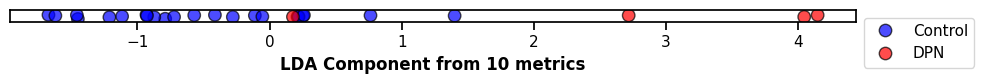

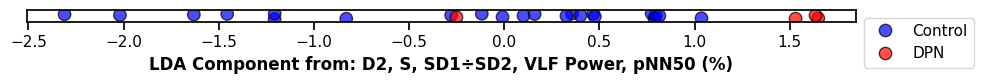

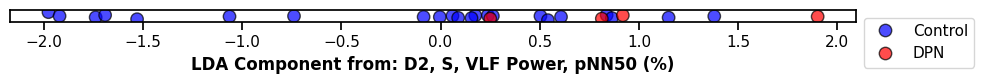

In [47]:
remaining_features, lda_df, lda = vif_reduction(median_pivot, n=20)
remaining_features, lda_df, lda = vif_reduction(median_pivot, n=15)
remaining_features, lda_df, lda = vif_reduction(median_pivot, n=10)
remaining_features, lda_df, lda = vif_reduction(median_pivot, n=5)
remaining_features, lda_df, lda = vif_reduction(median_pivot, n=4)

['SD1', 'SDRR', 'ApEn', 'Mean HR (bpm)', 'VLF Peak Frequency', 'DFA α1', 'LF Peak Frequency', 'RMSSD', 'HF Peak Frequency', 'DFA α2', 'SD2', 'LF÷HF Ratio', 'SampEn', 'LF Power', 'HF Power']


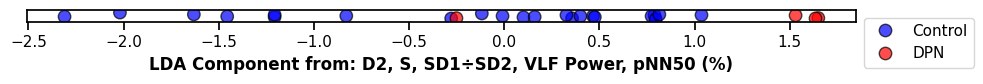

In [48]:
remaining_features, lda_df, lda = vif_reduction(median_pivot.copy(), n=5)